In [1]:
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
from skimage import data



In [3]:
import tempfile

# Create a temporary directory
d = tempfile.mkdtemp()

In [4]:
import os

# Return the tail of the path
os.path.basename('http://google.com/attention.zip')

'attention.zip'

In [5]:
from urllib.request import urlretrieve

# Define URL
url = 'http://www.fil.ion.ucl.ac.uk/spm/download/data/attention/attention.zip'

# Retrieve the data
fn, info = urlretrieve(url, os.path.join(d, 'attention.zip'))

In [6]:
import zipfile

# Extract the contents into the temporary directory we created earlier
zipfile.ZipFile(fn).extractall(path=d)

In [7]:
# List first 10 files
[f.filename for f in zipfile.ZipFile(fn).filelist[:10]]

['attention/',
 'attention/multi_block_regressors.mat',
 'attention/README_DATA.txt',
 'attention/factors.mat',
 'attention/functional/',
 'attention/functional/snffM00587_0201.hdr',
 'attention/functional/snffM00587_0040.img',
 'attention/functional/snffM00587_0458.hdr',
 'attention/functional/snffM00587_0185.img',
 'attention/functional/snffM00587_0018.hdr']

In [8]:
import nibabel

In [9]:
# Read the image 
struct = nibabel.load(os.path.join(d, 'attention/structural/nsM00587_0002.hdr'))

# Get a plain NumPy array, without all the metadata
struct_arr = struct.get_data()

/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """


In [10]:
from skimage import io

struct_arr = io.imread("https://s3.amazonaws.com/assets.datacamp.com/blog_assets/attention-mri.tif")

In [11]:
plt.imshow(struct_arr[75])

In [12]:
plt.imshow(struct_arr[75], aspect=0.5)

In [13]:
struct_arr2 = struct_arr.T
plt.imshow(struct_arr2[34])

In [14]:
plt.imshow(struct_arr2[5])

In [15]:
def previous_slice():
    pass

def next_slice():
    pass

def process_key(event):
    if event.key == 'j':
        previous_slice()
    elif event.key == 'k':
        next_slice()

In [16]:
fig, ax = plt.subplots()
ax.imshow(struct_arr[..., 43])
fig.canvas.mpl_connect('key_press_event', process_key)

<IPython.core.display.Javascript object>

9

In [17]:
def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

In [19]:
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

<IPython.core.display.Javascript object>


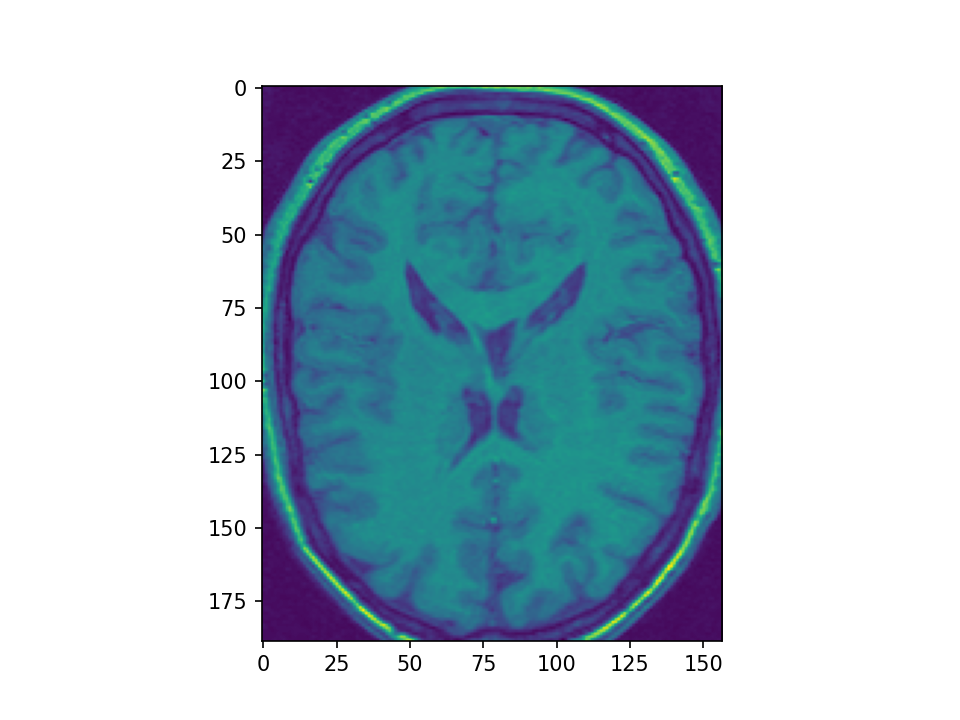

In [20]:
multi_slice_viewer(struct_arr2)

In [24]:
struct_arr2.shape

(68, 189, 157)

In [26]:
type(struct_arr2[0])

numpy.ndarray

In [27]:
struct_arr2[0].shape

(189, 157)

In [28]:
import shutil

# Remove the temporary directory
shutil.rmtree(d)

In [33]:
from pathlib import Path

In [35]:
mni0590 = Path('data/usq/images').ls().sorted()
seven_tensors = [tensor(Image.open(o)) for o in sevens]

AttributeError: 'PosixPath' object has no attribute 'ls'

In [ ]:
"""
==========================================================
Load CT slices and plot axial, sagittal and coronal images
==========================================================

This example illustrates loading multiple files, sorting them by slice
location, building a 3D image and reslicing it in different planes.

.. usage:

   reslice.py <glob>
   where <glob> refers to a set of DICOM image files.

   Example: python reslice.py "*.dcm". The quotes are needed to protect
   the glob from your system and leave it for the script.

.. note:

   Uses numpy and matplotlib.

   Tested using series 2 from here
   http://www.pcir.org/researchers/54879843_20060101.html
"""

import pydicom
import numpy as np
import matplotlib.pyplot as plt
import sys
import glob

# load the DICOM files
files = []
print('glob: {}'.format(sys.argv[1]))
for fname in glob.glob(sys.argv[1], recursive=False):
    print("loading: {}".format(fname))
    files.append(pydicom.dcmread(fname))

print("file count: {}".format(len(files)))

# skip files with no SliceLocation (eg scout views)
slices = []
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1

print("skipped, no SliceLocation: {}".format(skipcount))

# ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)

# pixel aspects, assuming all slices are the same
ps = slices[0].PixelSpacing
ss = slices[0].SliceThickness
ax_aspect = ps[1]/ps[0]
sag_aspect = ps[1]/ss
cor_aspect = ss/ps[0]

# create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d

# plot 3 orthogonal slices
a1 = plt.subplot(2, 2, 1)
plt.imshow(img3d[:, :, img_shape[2]//2])
a1.set_aspect(ax_aspect)

a2 = plt.subplot(2, 2, 2)
plt.imshow(img3d[:, img_shape[1]//2, :])
a2.set_aspect(sag_aspect)

a3 = plt.subplot(2, 2, 3)
plt.imshow(img3d[img_shape[0]//2, :, :].T)
a3.set_aspect(cor_aspect)

plt.show()

In [3]:
## matplotlib

In [5]:
import sys

In [9]:
import fastcore

ModuleNotFoundError: No module named 'fastcore'

In [6]:
sys.path.append('/home/msadmin/notebooks/msc8001/src')
images_directory =  "../data/usq/images/"
masks_directory = "../data/usq/masks/"

In [10]:
import os
raw_images = os.listdir('../data/usq/images')
raw_masks = os.listdir('../data/usq/masks')

X_test = [tensor(Image.open(o)) for o in raw_images]
y_test = [tensor(Image.open(o)) for o in raw_masks]

NameError: name 'tensor' is not defined

In [ ]:
import matplotlib.animation as animation

fig = plt.figure()
slices = []
for i in range(128):
    
    ax = plt.imshow(X_test[0, :, :, i, 0], animated=True)
    ax = plt.imshow(y_test[0, :, :, i, 1:4], animated=True, interpolation='none', alpha=0.5)
    slices.append([ax])
    
ani = animation.ArtistAnimation(fig, slices, interval=50, blit=True,
                                repeat_delay=500)
ani.save('dynamic_images.mp4')
plt.show()

In [1]:

# creating 3d plot using matplotlib 
# in python
  
# for creating a responsive plot
%matplotlib widget
  
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
  
# creating random dataset
xs = [14, 24, 43, 47, 54, 66, 74, 89, 12,
      44, 1, 2, 3, 4, 5, 9, 8, 7, 6, 5]
  
ys = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 6, 3,
      5, 2, 4, 1, 8, 7, 0, 5]
  
zs = [9, 6, 3, 5, 2, 4, 1, 8, 7, 0, 1, 2, 
      3, 4, 5, 6, 7, 8, 9, 0]
  
# creating figure
fig = plt.figure()
ax = Axes3D(fig)
  
# creating the plot
plot_geeks = ax.scatter(xs, ys, zs, color='green')
  
# setting title and labels
ax.set_title("3D plot")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
  
# displaying the plot
plt.show()

ModuleNotFoundError: No module named 'ipympl'